# 任务二 RNN-LSTM图像分类

每一笔画的数据总共5维；
每个图像最多139/62……划；
每个数据集有70000张图像


## 2.1 数据展示

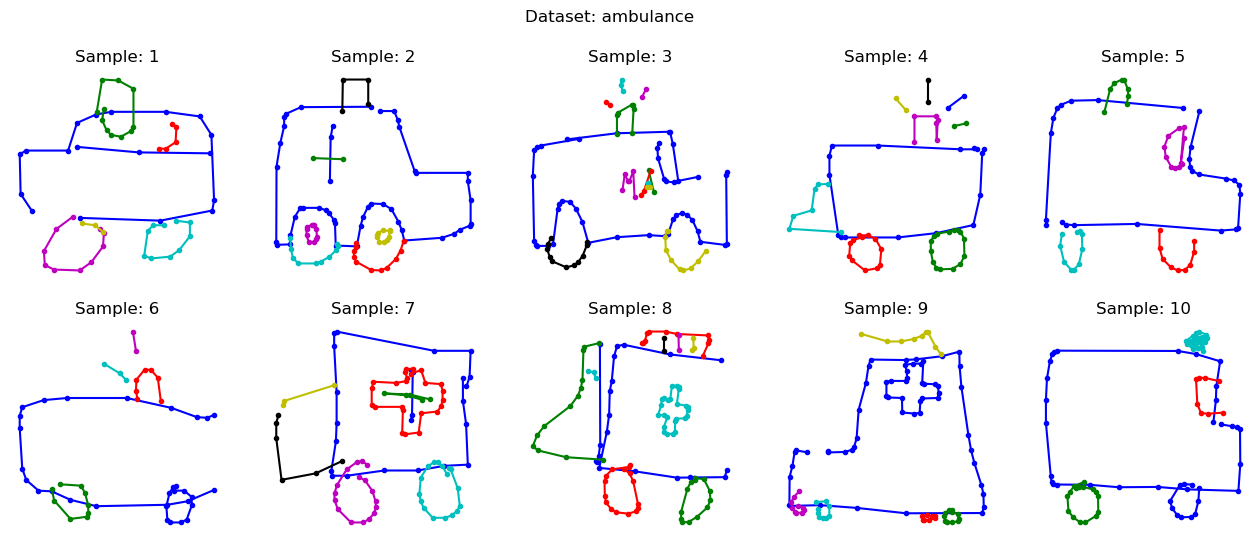

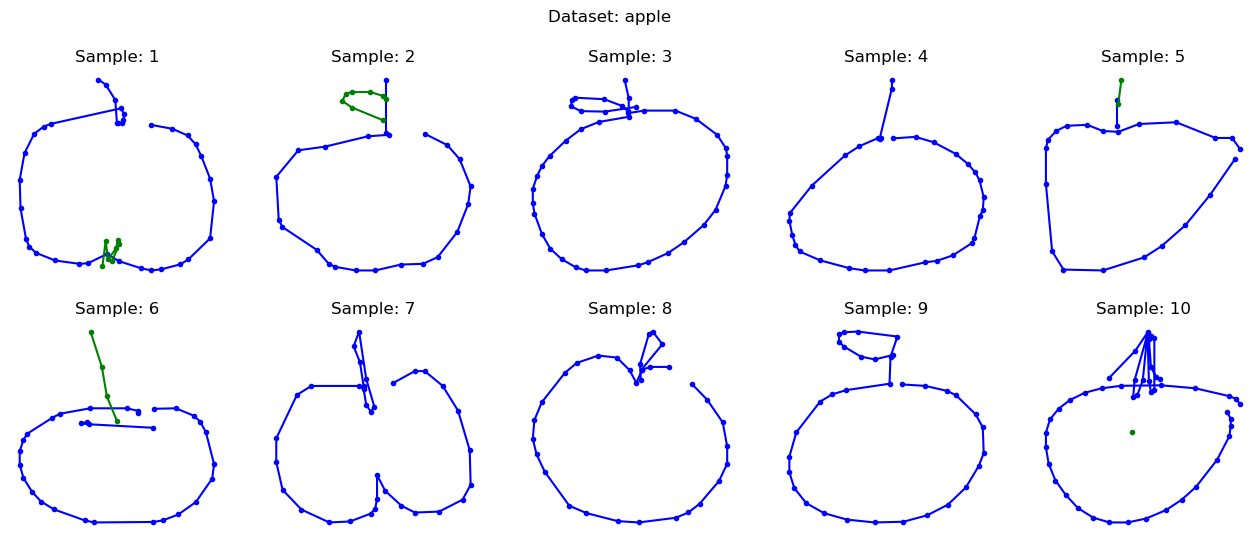

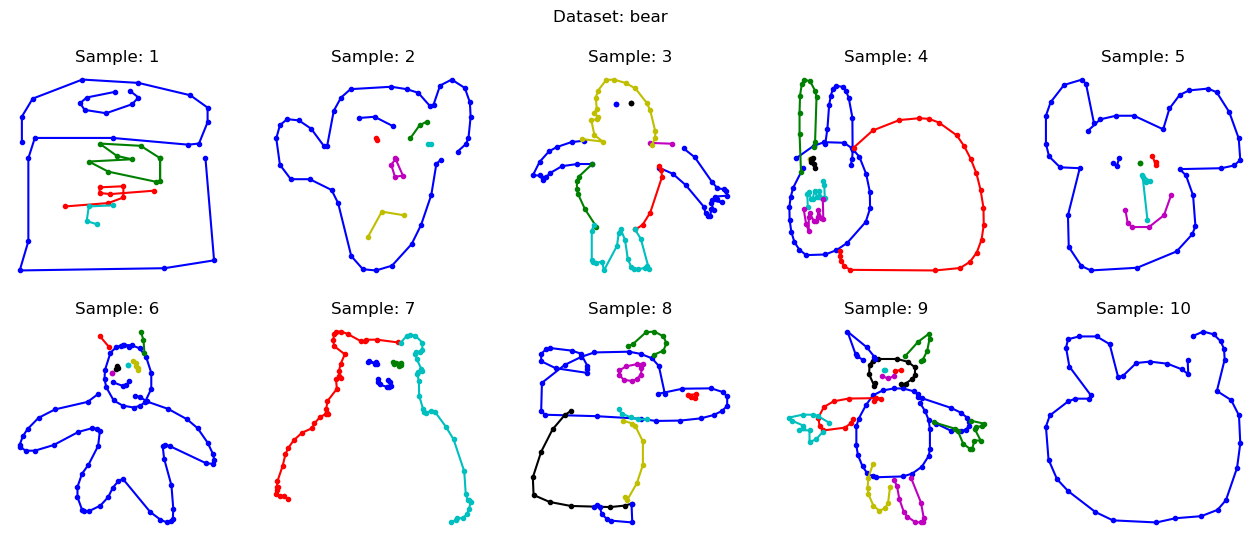

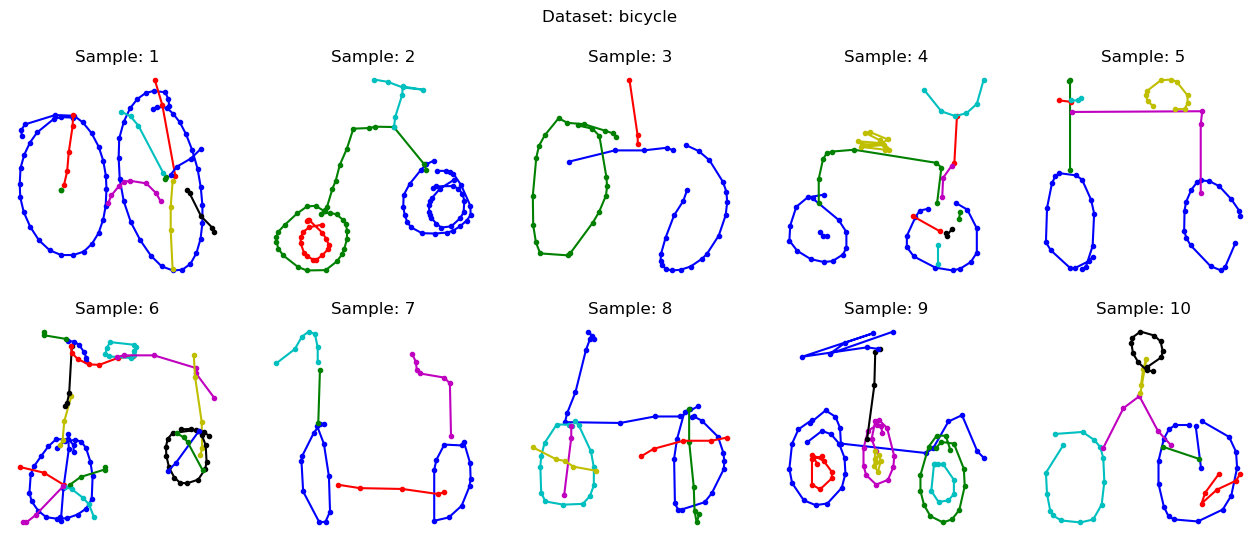

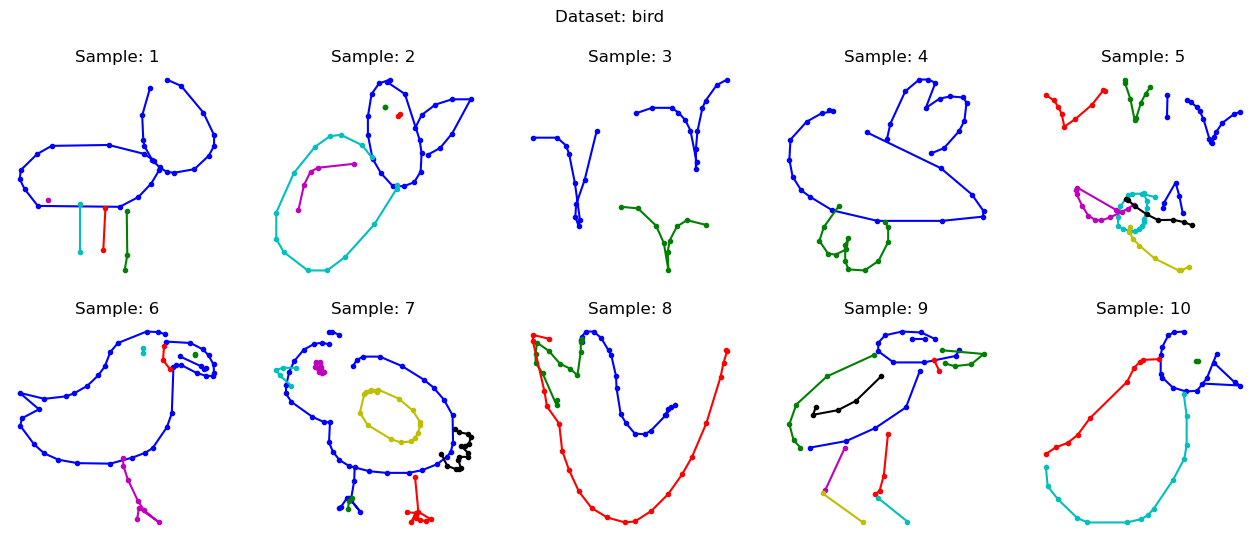

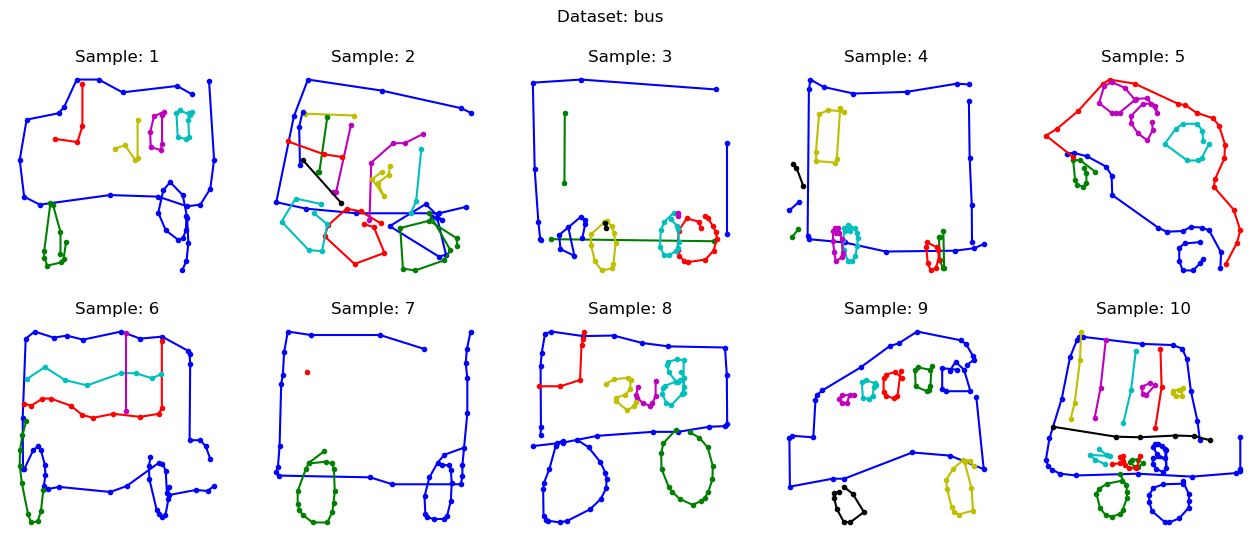

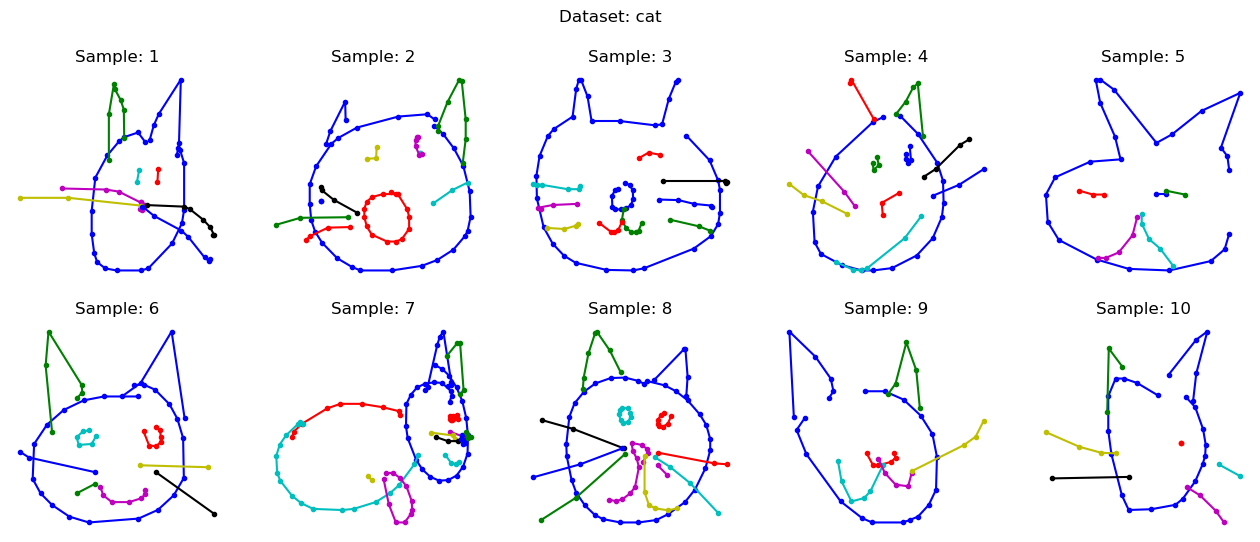

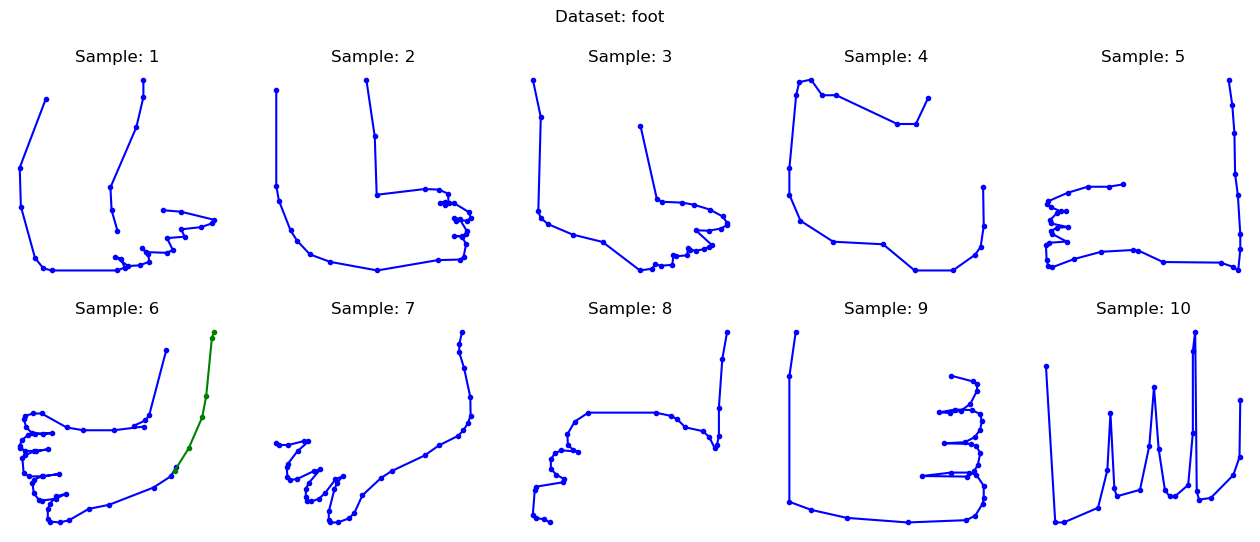

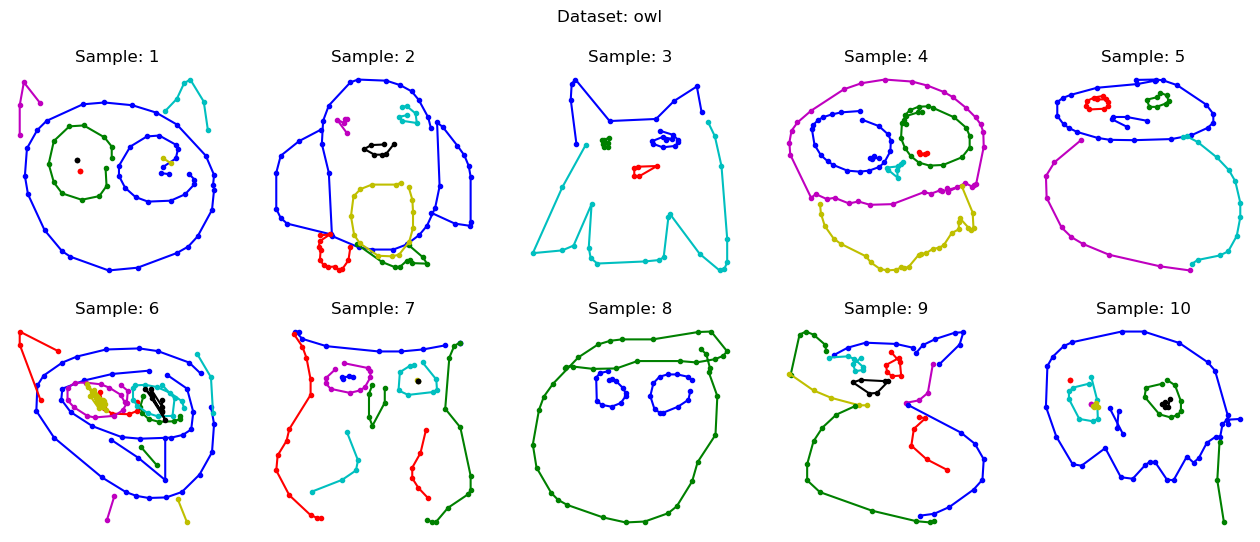

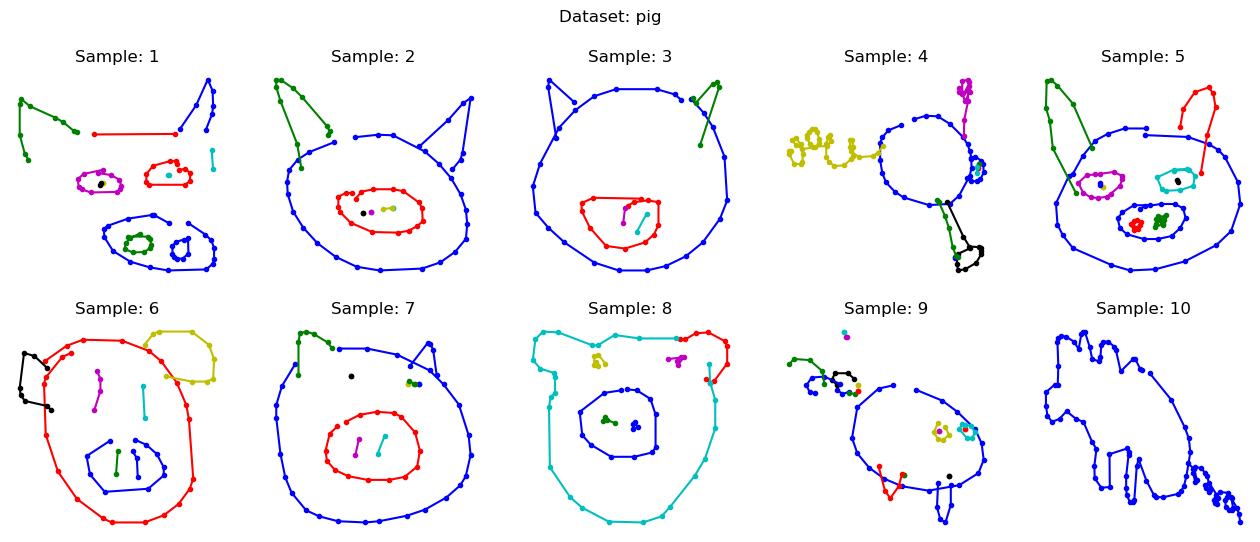

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 标签定义
# ‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’,‘foot’,‘owl’,‘pig‘
# 获取所有标签
labels = ['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']

# 路径
file_path = './2023-GAI-实验4-手绘图点序列数据集/sketch_datas'

def read_and_show_data(path, dataset_name, show_num):
    file = np.load(path + '/' + dataset_name + '.npy')
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']    # 创建一个颜色列表，用于标识不同的点序列
    # 从数组中随机抽取元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  


    # 绘图
    plt.figure(figsize=(16, 6))
    for i in range(show_num):
        plt.subplot(2, 5, i+1) 
        image_data = random_samples[i]

        axis = np.cumsum(image_data[:,:2], axis=0)
        track = []
        color_index = 0
        color = colors[0]

        # 具体绘图
        for j in range(axis.shape[0]):
            track.append([-axis[j][0], -axis[j][1]])

            if image_data[j][4] == 1.: # 绘画结束
                plt.plot(*zip(*track), marker='.', color=color)
                track = []
                break

            if image_data[j][3] == 1.: # 画笔抬起
                plt.plot(*zip(*track), marker='.', color=color)
                track = []
                color = colors[(color_index)%len(colors)]
                color_index += 1

        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    # # 每张图片数据reshape
    # data = []
    # for pic in file:
    #     data.append(pic.reshape(1,28,28)) # channel，height，width
    

    # return np.array(data) # 使用np数组



read_and_show_data(file_path, 'ambulance', 10) 
read_and_show_data(file_path, 'apple', 10)
read_and_show_data(file_path, 'bear', 10)
read_and_show_data(file_path, 'bicycle', 10)
read_and_show_data(file_path, 'bird', 10)
read_and_show_data(file_path, 'bus', 10)
read_and_show_data(file_path, 'cat', 10)
read_and_show_data(file_path, 'foot', 10)
read_and_show_data(file_path, 'owl', 10)
read_and_show_data(file_path, 'pig', 10)


## 2.2 数据读取并调整

In [2]:
import os


# 读取数据
ratios = [0.7, 0.2, 0.1]

# 用于保存特征和标签的列表
features = []
target_labels = []

# 创建训练集、验证集和分布内测试集的列表
train_features = []
train_labels = []
val_features = []
val_labels = []
in_test_features = []
in_test_labels = []

# 遍历每个标签
for label in labels:
    npy_file = f"{label}.npy"
    npy_file_path = os.path.join(file_path, npy_file)
    # 读取.npy文件中的特征
    feature = np.load(npy_file_path)
    # 将特征和标签添加到列表中
    features.append(feature)
    target_labels.append(label)
    print(f"label : {label}, shape of feature : {feature.shape}")
# 将标签转换为NumPy数组
target_labels = np.array(target_labels)
print("Target labels shape:", target_labels.shape)


# 按照比例划分数据集
for cls_idx in range(7):
    # 获取当前类别的特征和标签
    cls_features = features[cls_idx]
    new_features = np.zeros((70000,256,5))
    new_features[:, :, 4] = 1.0
    new_features[:, :cls_features.shape[1], :] = cls_features
    cls_features = new_features
    # pad_width = [(0, 0), (0, target_shape[1] - cls_features.shape[1]), (0, 0)]
    # cls_features = np.pad(cls_features, pad_width, mode='constant', constant_values=[[0.0, 0.0, 0.0, 0.0, 1.0]])
    # print(cls_features.shape)

    cls_labels = cls_idx
    
    # 计算每个划分的数量
    total_samples = cls_features.shape[0]
    train_count = int(total_samples * ratios[0])
    val_count = int(total_samples * ratios[1])
    
    # 随机抽样划分数据集
    train_indices = np.random.choice(total_samples, train_count, replace=False)
    val_indices = np.random.choice(list(set(range(total_samples)) - set(train_indices)), val_count, replace=False)
    in_test_indices = list(set(range(total_samples)) - set(train_indices) - set(val_indices))
    
    # 将特征和标签添加到对应的数据集中
    train_features.extend(cls_features[i] for i in train_indices)
    train_labels.extend(cls_labels for _ in train_indices)
    val_features.extend(cls_features[i] for i in val_indices)
    val_labels.extend(cls_labels for _ in val_indices)
    in_test_features.extend(cls_features[i] for i in in_test_indices)
    in_test_labels.extend(cls_labels for _ in in_test_indices)

# 将列表转换为NumPy数组
train_features = np.array(train_features)
train_labels = np.array(train_labels)
val_features = np.array(val_features)
val_labels = np.array(val_labels)
in_test_features = np.array(in_test_features)
in_test_labels = np.array(in_test_labels)


# ood数据单独处理
ood_test_features = []
ood_test_labels = []

# 遍历每个类别
for cls in range(3):
    # 获取当前类别的特征和标签
    cls_idx = cls+7
    cls_features = features[cls_idx]
    new_features = np.zeros((70000,256,5))
    new_features[:, :, 4] = 1.0
    new_features[:, :cls_features.shape[1], :] = cls_features
    cls_features = new_features
    cls_labels = cls_idx
    
    # 随机抽样100个样本作为分布外测试数据集
    indices = np.random.choice(cls_features.shape[0], 100, replace=False)
    
    # 将特征和标签添加到分布外测试数据集中
    ood_test_features.extend(cls_features[i] for i in indices)
    ood_test_labels.extend(cls_labels for _ in indices)

# 将列表转换为NumPy数组
ood_test_features = np.array(ood_test_features)
ood_test_labels = np.array(ood_test_labels)

label : ambulance, shape of feature : (70000, 139, 5)
label : apple, shape of feature : (70000, 62, 5)
label : bear, shape of feature : (70000, 138, 5)
label : bicycle, shape of feature : (70000, 116, 5)
label : bird, shape of feature : (70000, 112, 5)
label : bus, shape of feature : (70000, 147, 5)
label : cat, shape of feature : (70000, 129, 5)
label : foot, shape of feature : (70000, 81, 5)
label : owl, shape of feature : (70000, 148, 5)
label : pig, shape of feature : (70000, 151, 5)
Target labels shape: (10,)


## 2.3 定义网络结构

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# 定义双向LSTM模型
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 前向LSTM
        self.lstm_forward = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 后向LSTM
        self.lstm_backward = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0_forward = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0_forward = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        h0_backward = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0_backward = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播
        out_forward, _ = self.lstm_forward(x, (h0_forward, c0_forward))
        
        # 反向传播
        out_backward, _ = self.lstm_backward(torch.flip(x, [1]), (h0_backward, c0_backward))
        
        # 拼接两个方向的隐藏状态
        out = torch.cat((out_forward[:, -1, :], out_backward[:, -1, :]), dim=1)
        
        # 全连接层
        out = self.fc(out)
        return out

## 2.4 训练

In [4]:
import time
import torch.optim as optim

# 打印与轮次有关的信息（acc、loss）
def show_info(epochs, acc_list, loss_list, val_acc_list, val_loss_list):
    plt.figure(figsize=(16, 4))
    
    plt.suptitle("Acc and Loss in each epoch")
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, epochs + 1, dtype=int), acc_list, label='acc')
    plt.plot(np.arange(1, epochs + 1, dtype=int), val_acc_list, label='val_acc')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, epochs + 1, dtype=int), loss_list, label='loss')
    plt.plot(np.arange(1, epochs+1, dtype=int), val_loss_list, label='val_loss')
    plt.legend()


    plt.show()

    
# 使用倒入的数据进行训练，最终将模型保存为文件
def train(model, device, learning_rate, num_epochs, batch_size, train_data, val_data):
    # 定义损失函数和优化器
    CE = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练模型
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # 尝试多个batch_size训练

    # 模型选择
    val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
    best_val_loss = float('inf')
    best_model = model
    best_epoch = 0
    best_val_loss = 99999999


    running_loss = [] #记录loss变化
    valling_loss = [] #记录val_loss变化
    start_time = time.time() # 记时
    train_acc_list = [] # 记录训练acc变化
    val_acc_list = []
    for epoch in range(num_epochs):
        running_loss.append(0.0)
        acc = 0

        model.to(device)

        # 训练
        model.train()
        for x, y in train_loader:
            x = x.float().to(device)
            y = y.long().to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            
            loss = CE(y_hat, y)
            loss.backward()
            optimizer.step()

            running_loss[epoch] += loss.item()

            # acc记录
            acc += torch.sum(torch.max(y_hat, 1)[1] == y).item()

        # 验证与选优（记录acc）
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0
            for x_val, y_val in val_loader:
                x_val = x_val.float().to(device)
                y_val = y_val.long().to(device)

                y_val_hat = model(x_val)
                val_loss += CE(y_val_hat, y_val).item()

                val_acc += torch.sum(torch.max(y_val_hat, 1)[1] == y_val).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_epoch = epoch
            
            valling_loss.append(val_loss)
                
        
        train_acc_list.append(acc/len(train_data))
        val_acc_list.append(val_acc/len(val_data))
        

        # 早停
        if epoch > num_epochs/3 or epoch > 10:
            # 观察cost记录中最后10个数据，如果变化幅度不超过1%，就停止
            stop_flag = False
            if len(running_loss) > 10:
                last_10_costs = np.array(running_loss)[-10:]
                max_cost = max(last_10_costs)
                min_cost = min(last_10_costs)
                if (max_cost - min_cost) / max_cost < 0.01:
                    stop_flag = True
            if stop_flag:
                print(f"Training stopped due to small loss change in epoch {epoch}.")
                break    


        # 过程信息打印
        if epoch % 1 == 0:
            epoch_end_time = time.time()
            print(f"epoch: {epoch+1 :3} cost {(epoch_end_time - start_time):.2f}s after last print, sum loss: {running_loss[epoch]:.3f}")
            start_time = epoch_end_time

            
    print(f"Finished Training, best model saved in epoch {best_epoch+1} with val loss: {best_val_loss:.3f}")

    show_info(num_epochs, acc_list=train_acc_list, loss_list=running_loss, val_acc_list=val_acc_list, val_loss_list=valling_loss)

    # 保存模型
    torch.save(best_model.state_dict(), f"trained_{model._get_name()}_lstm_model_{num_epochs}epochs.pth")

In [5]:
train_features = torch.from_numpy(train_features)
train_labels = torch.from_numpy(train_labels)
train_data = TensorDataset(train_features, train_labels)


val_features = torch.from_numpy(val_features) 
val_labels = torch.from_numpy(val_labels) 
val_data = TensorDataset(val_features, val_labels) 

epoch:   1 cost 880.55s after last print, sum loss: 3109.148
epoch:   2 cost 961.98s after last print, sum loss: 2094.871
epoch:   3 cost 931.97s after last print, sum loss: 1905.315
Finished Training, best model saved in epoch 3 with val loss: 336.368


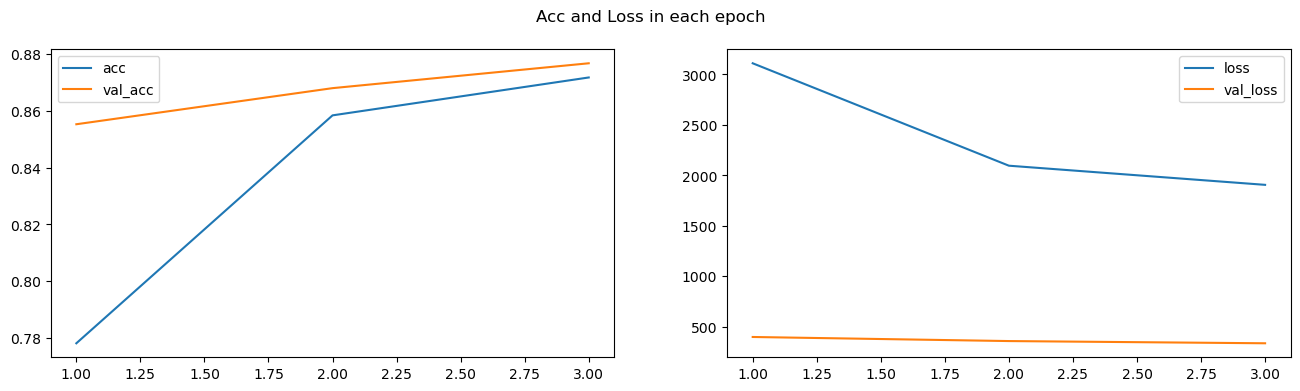

训练时间太长，仅作示例，使用之前训练好的一个10轮模型作为之后的测试模型


In [11]:
# 定义输入数据
input_size = 5
sequence_length = 256
num_classes = 10
hidden_size = 128
num_layers = 3

device = "mps"
batch_size = 64
epochs = 3

model = BiLSTM(input_size, hidden_size, num_layers, num_classes)

train(model, device, 0.01, epochs, batch_size, train_data, val_data)
print("训练时间太长，仅作示例，使用之前训练好的一个10轮模型作为之后的测试模型")

## 2.5 测试与展示

In [ ]:
# 加载测试数据
in_test_features = torch.from_numpy(in_test_features) 
in_test_labels = torch.from_numpy(in_test_labels)
in_test_data = TensorDataset(in_test_features, in_test_labels) 
# in_test_loader = DataLoader(in_test_data, batch_size=64, shuffle=False)

ood_test_features = torch.from_numpy(ood_test_features) 
ood_test_labels = torch.from_numpy(ood_test_labels) 
ood_test_data = TensorDataset(ood_test_features, ood_test_labels) 
# ood_test_loader = DataLoader(ood_test_data, batch_size=64, shuffle=False)

In [ ]:
# 绘图展示结果概率分布
def show_result(path, dataset_name, y_hat, show_num = 10):
    file = np.load(path + '/' + dataset_name + '.npy')

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']    # 创建一个颜色列表，用于标识不同的点序列
    # 从数组中随机抽取元素的索引
    random_indices = np.random.choice(len(y_hat), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices] 
    random_result = nn.functional.softmax(y_hat, dim=1)[random_indices] # 转换为概率 


    # 绘图
    plt.figure(figsize=(16, 6))
    for i in range(show_num):
        plt.subplot(2, 5, i+1) 
        image_data = random_samples[i]

        axis = np.cumsum(image_data[:,:2], axis=0)
        track = []
        color_index = 0
        color = colors[0]

        # 具体绘图
        for j in range(axis.shape[0]):
            track.append([-axis[j][0], -axis[j][1]])

            if image_data[j][4] == 1.: # 绘画结束
                plt.plot(*zip(*track), marker='.', color=color)
                track = []
                break

            if image_data[j][3] == 1.: # 画笔抬起
                plt.plot(*zip(*track), marker='.', color=color)
                track = []
                color = colors[(color_index)%len(colors)]
                color_index += 1

        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    # 概率条形图
    plt.figure(figsize=(16,6))
    for i in range(show_num):
        plt.subplot(2, 5, i + 1) 
        plt.ylim(0, 1, 0.1)
        plt.xticks(range(10))
        plt.bar([0,1,2,3,4,5,6,7,8,9], random_result[i])
        plt.title(f"Sample {i+1} Predict")
    
    plt.show()
    
# 模型测试并输出图像结果示例
def model_test(model, device, test_data_set, test_data_set_class):
    test_loader = DataLoader(test_data_set, batch_size=64, shuffle=False)

    acc = 0.0
    y_hat = torch.tensor([]).to(device)

    model.to(device)
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.float().to(device)
            y = y.long().to(device)

            y_pred = model(x)
            acc += torch.sum(torch.max(y_pred, 1)[1] == y).item()
            y_hat = torch.cat((y_hat, y_pred), dim=0)

        acc = acc/len(in_test_data)

    # 输出结果示例
    if test_data_set_class == 'in':
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'ambulance', y_hat[:len(y_hat)//7].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'apple', y_hat[len(y_hat)//7:len(y_hat)//7*2].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'bear', y_hat[len(y_hat)//7*2:len(y_hat)//7*3].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'bicycle', y_hat[len(y_hat)//7*3:len(y_hat)//7*4].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'bird', y_hat[len(y_hat)//7*4:len(y_hat)//7*5].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'bus', y_hat[len(y_hat)//7*5:len(y_hat)//7*6].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'cat', y_hat[len(y_hat)//7*6:len(y_hat)//7*7].to('cpu'), 10)
    elif test_data_set_class == 'out':
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'pig', y_hat[:len(y_hat)//3].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'owl', y_hat[len(y_hat)//3:len(y_hat)//3*2].to('cpu'), 10)
        show_result('./2023-GAI-实验4-手绘图点序列数据集/sketch_datas/', 'foot', y_hat[len(y_hat)//3*2:].to('cpu'), 10)


    print(f"{test_data_set_class} data acc:{acc:.3f}") 

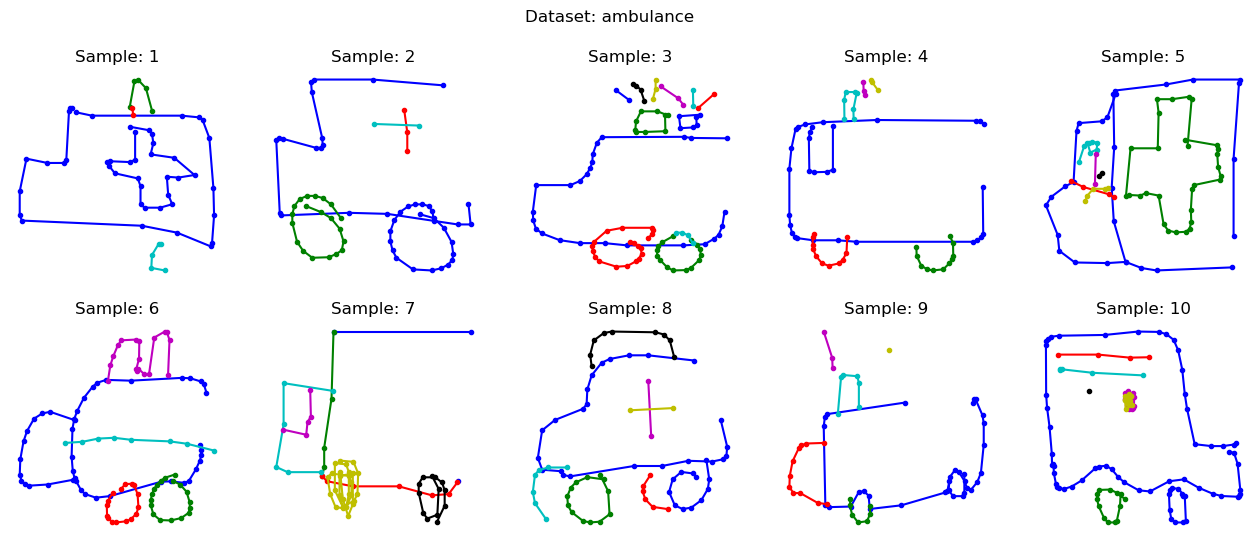

/var/folders/dm/cmsrk78d5nj0z9l_9zyb6yjc0000gn/T/ipykernel_91296/1766991405.py:49: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 1, 0.1)


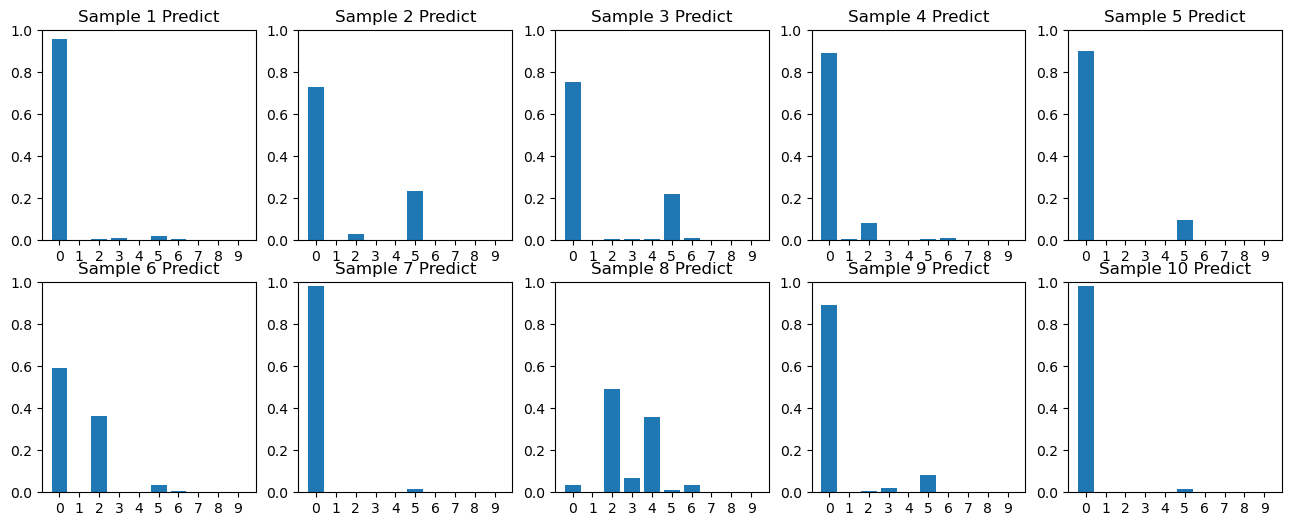

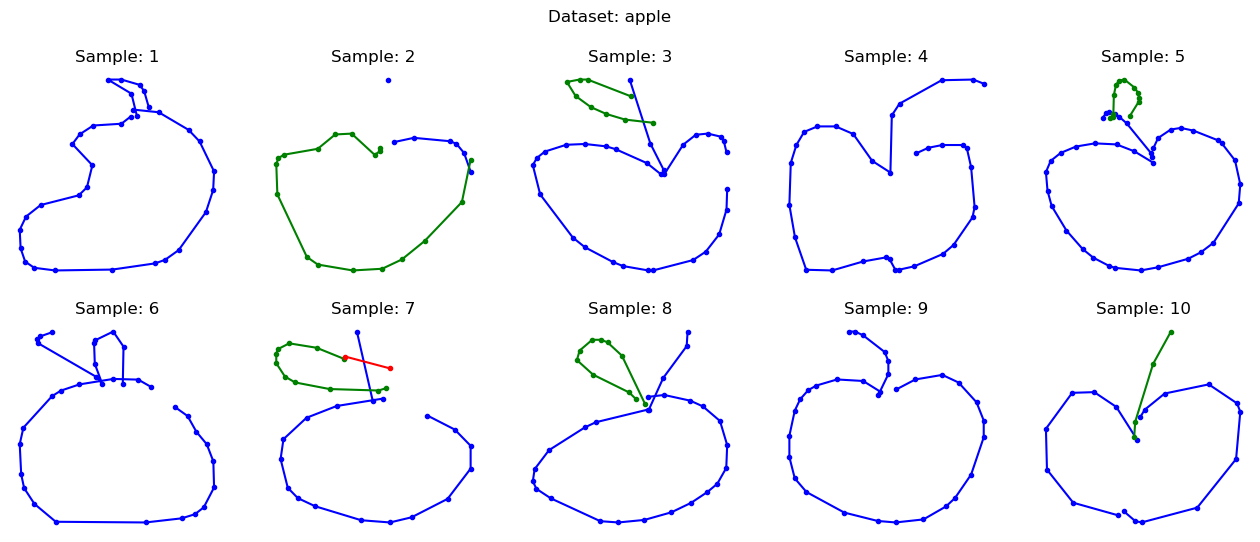

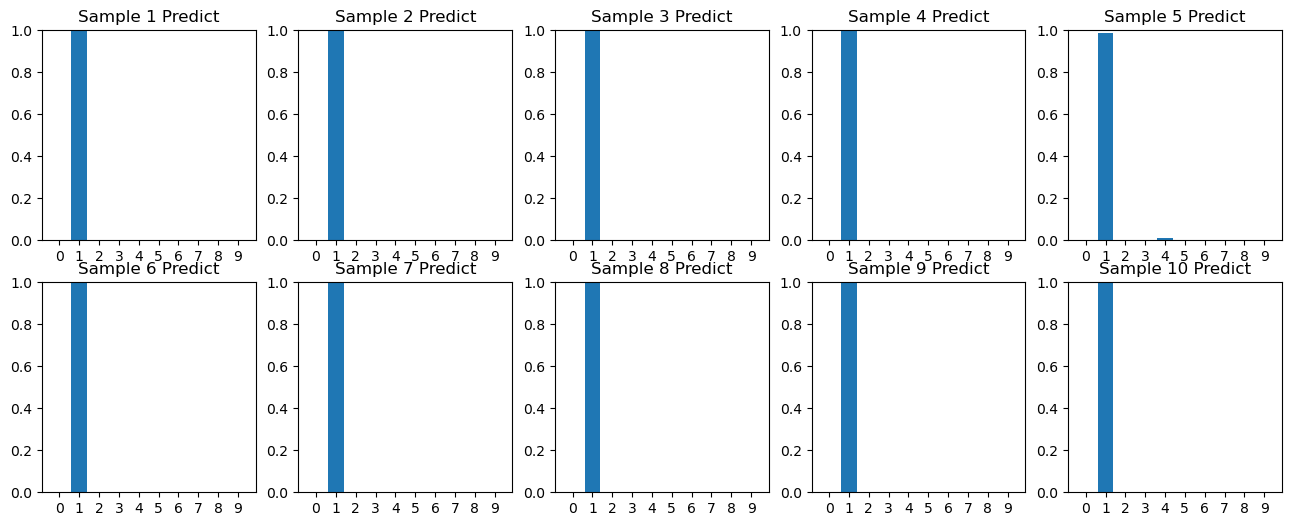

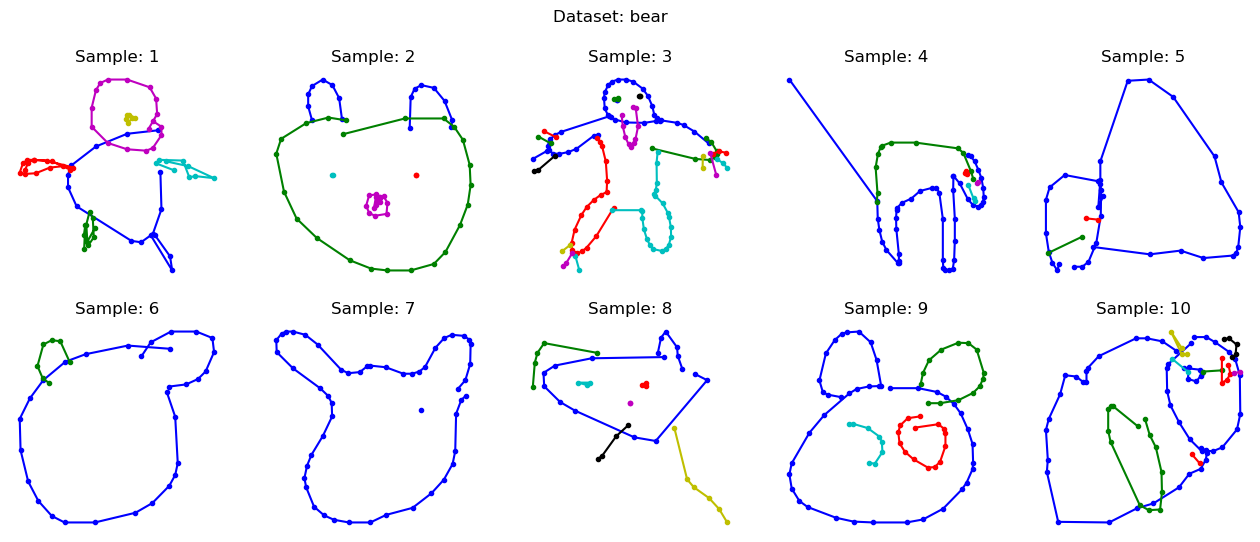

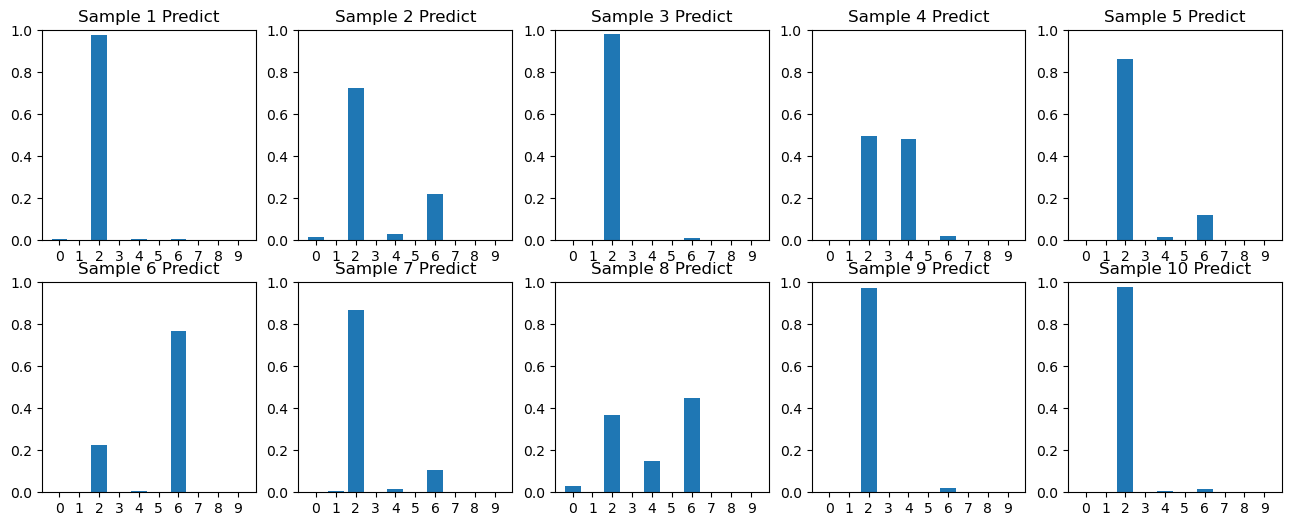

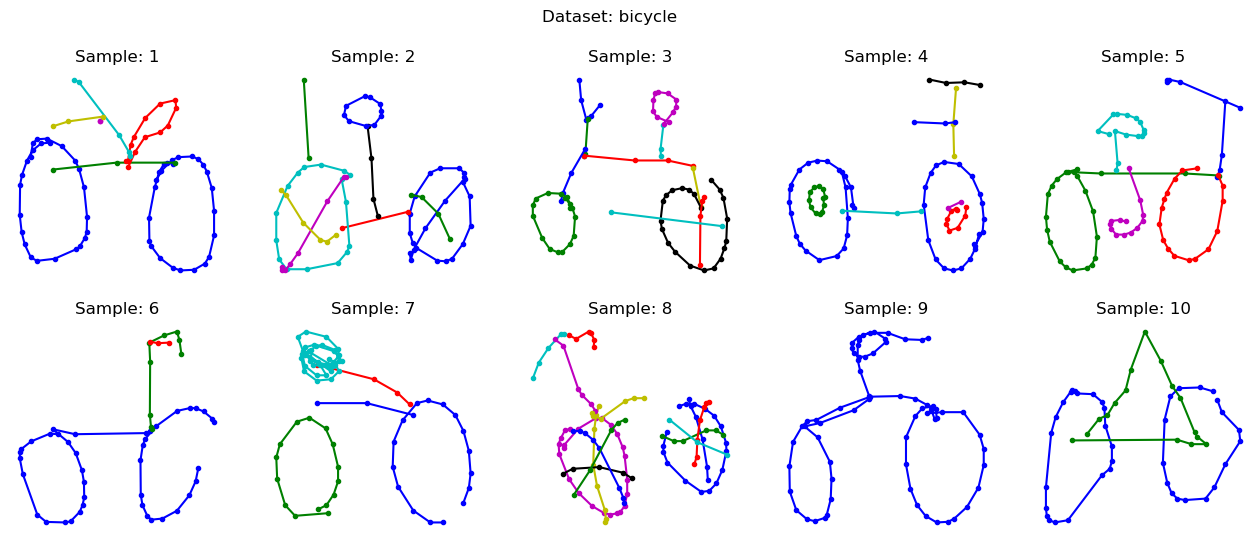

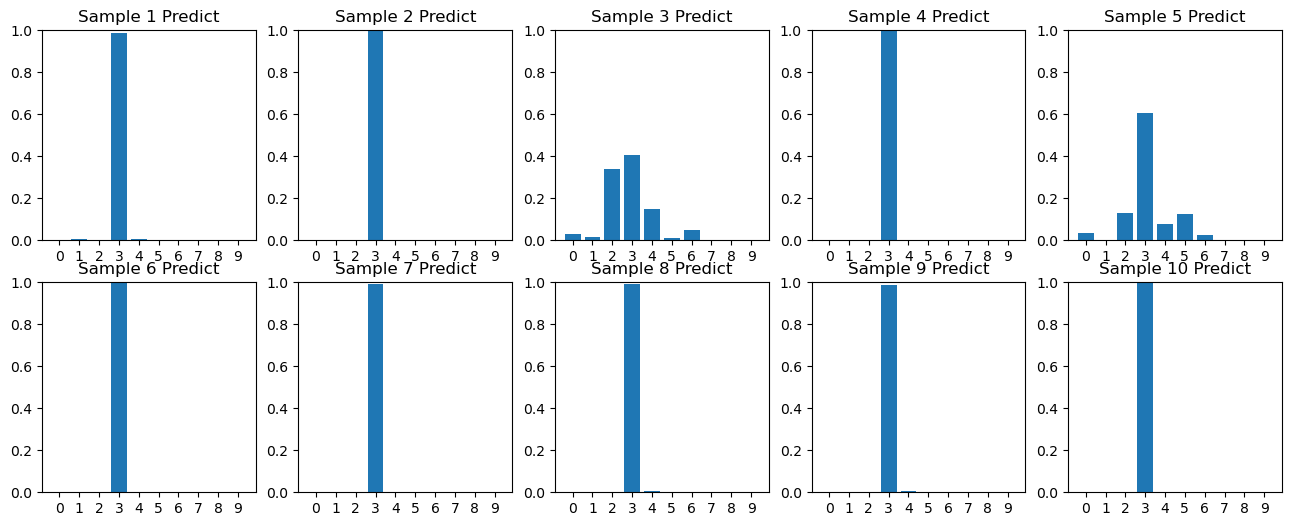

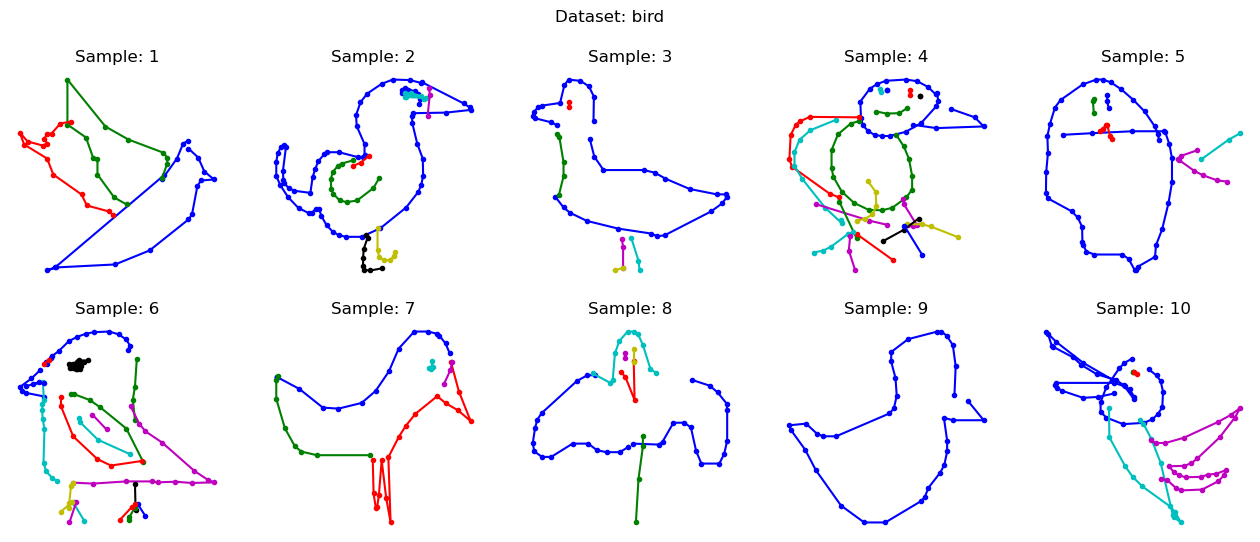

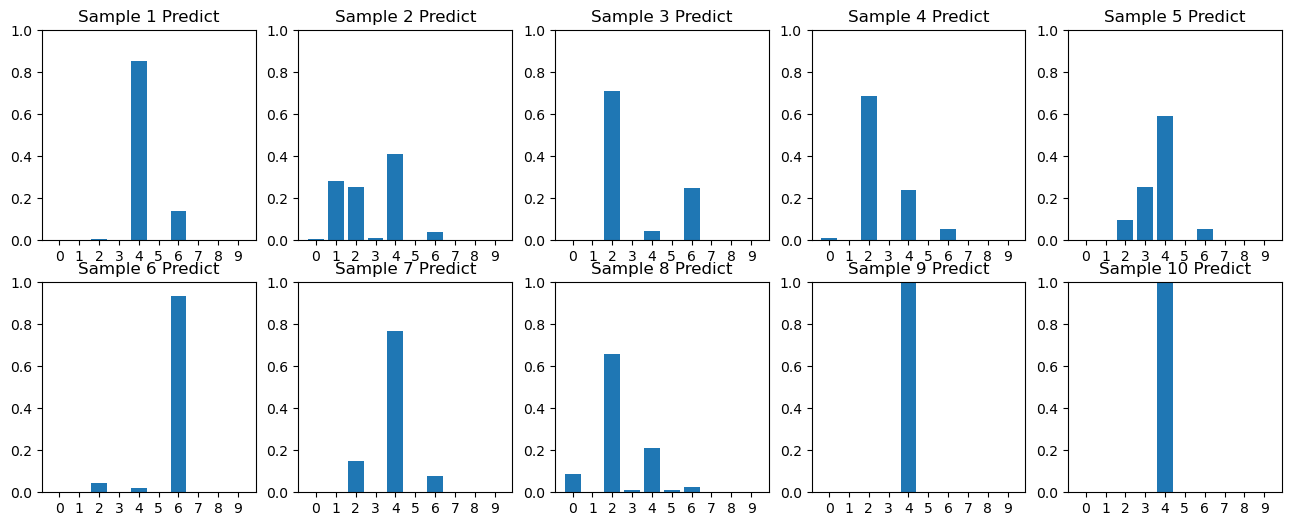

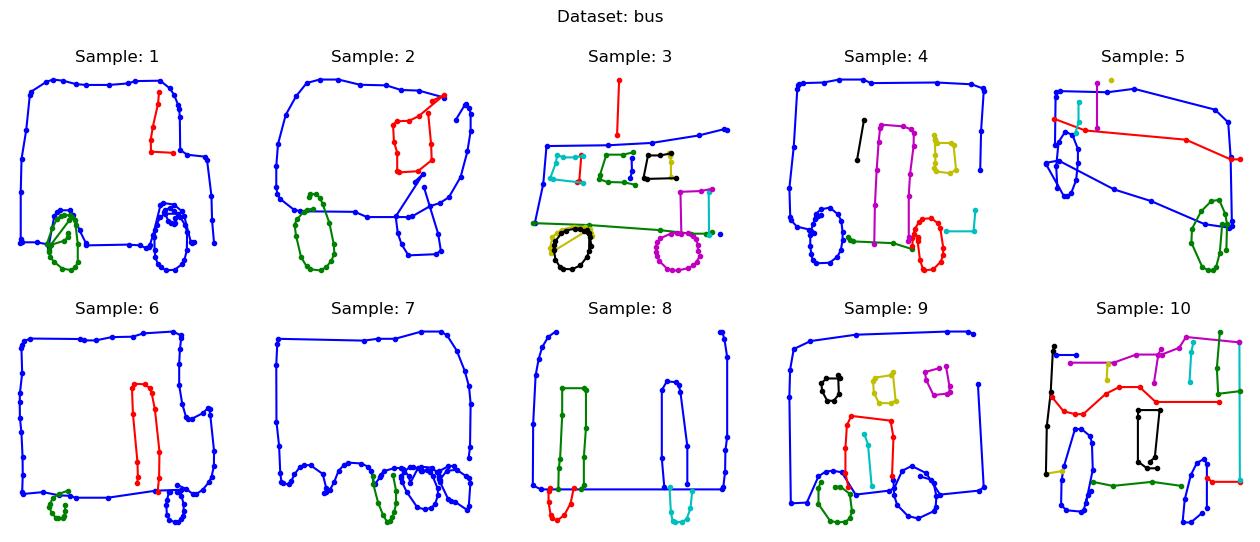

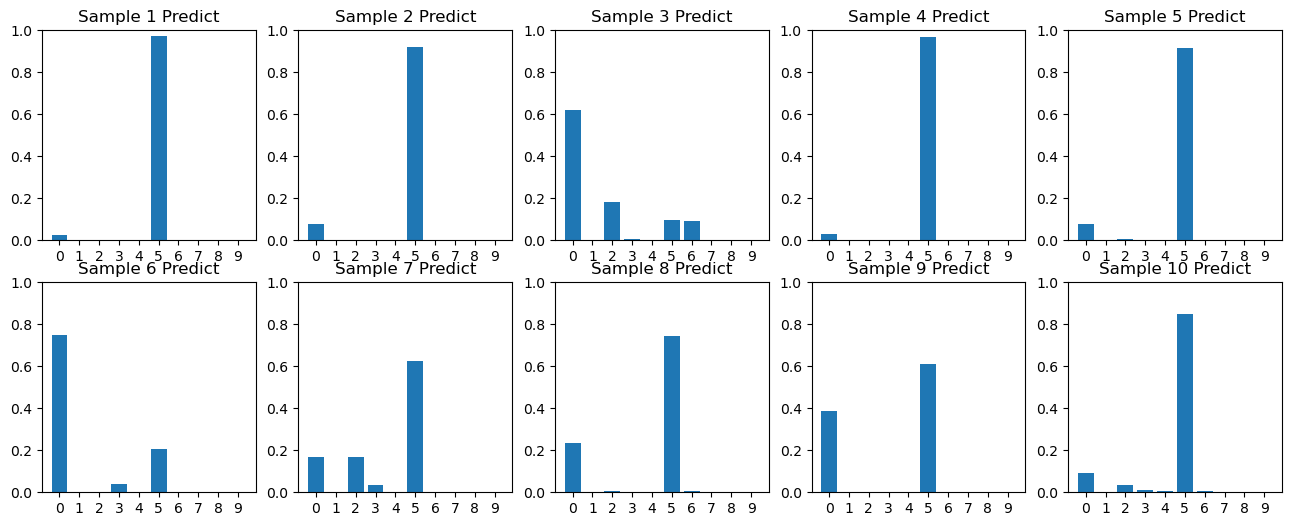

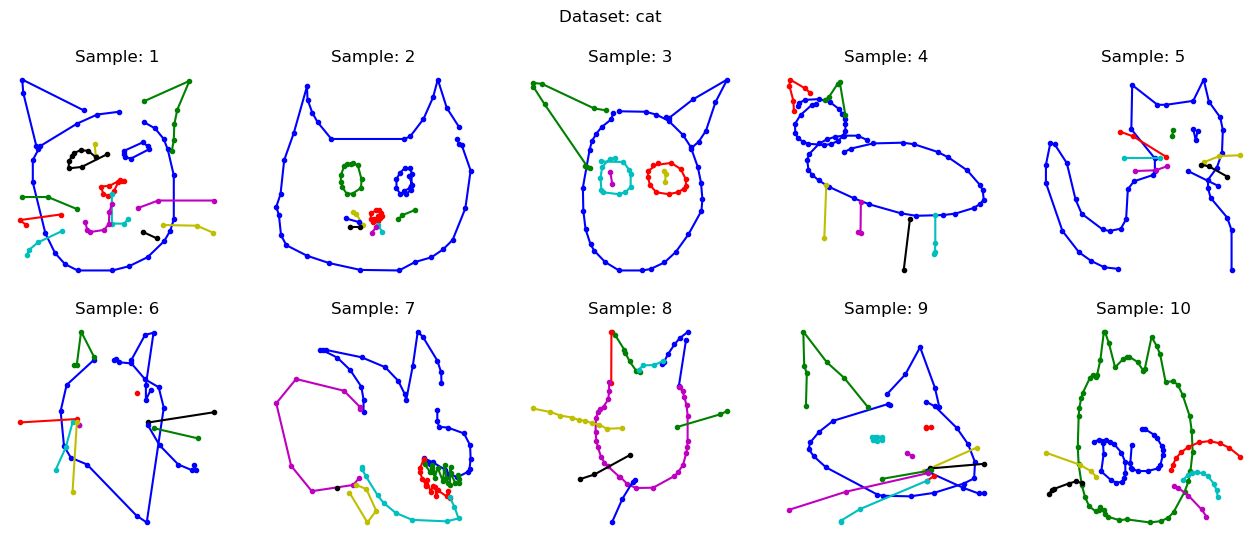

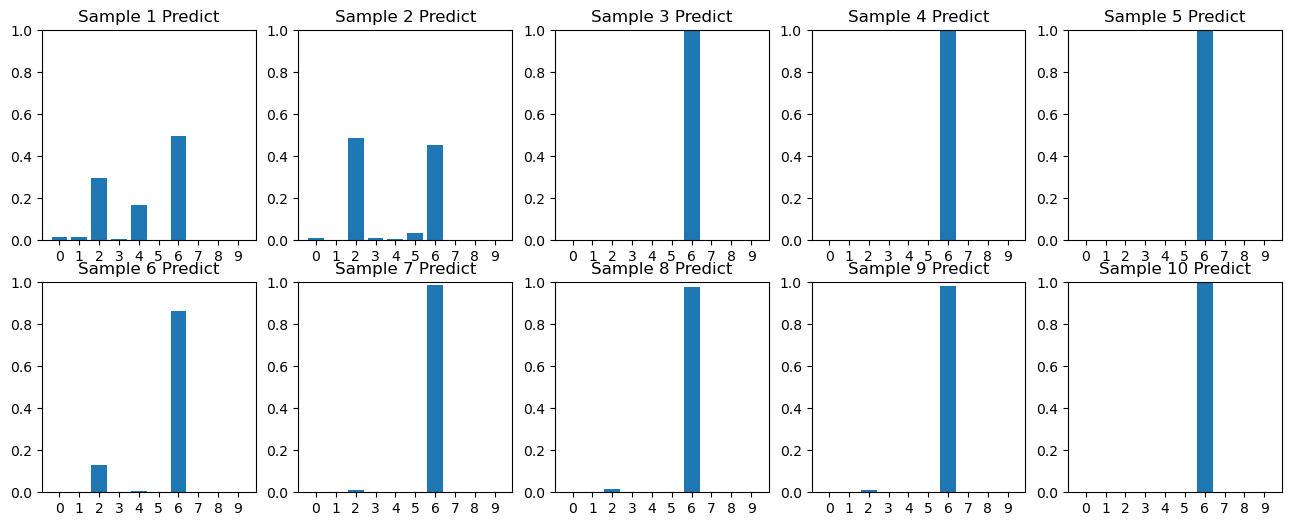

in data acc:0.824


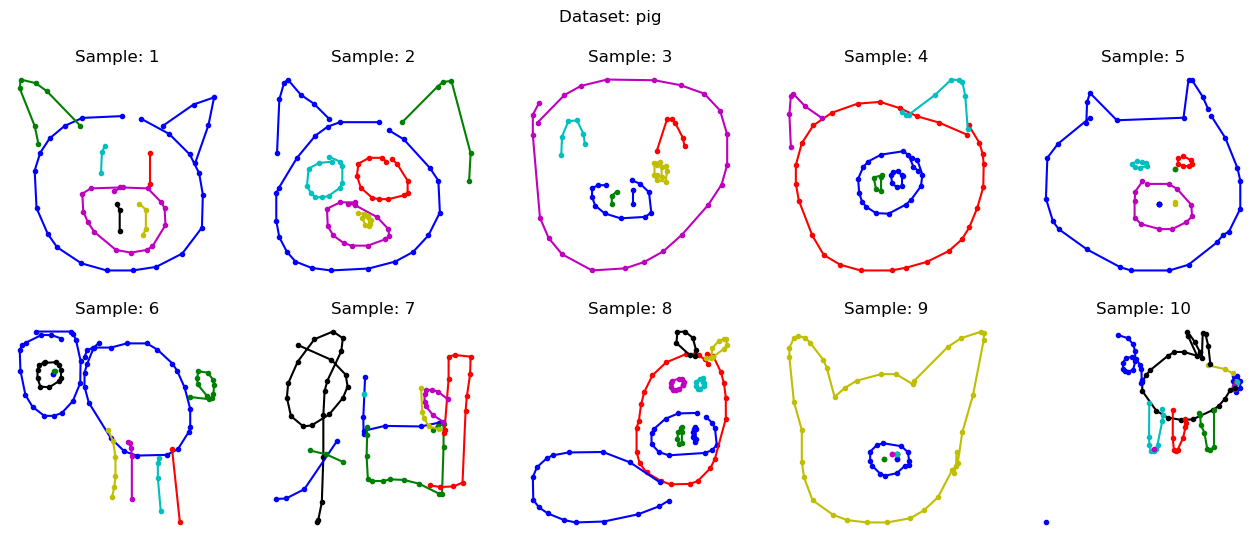

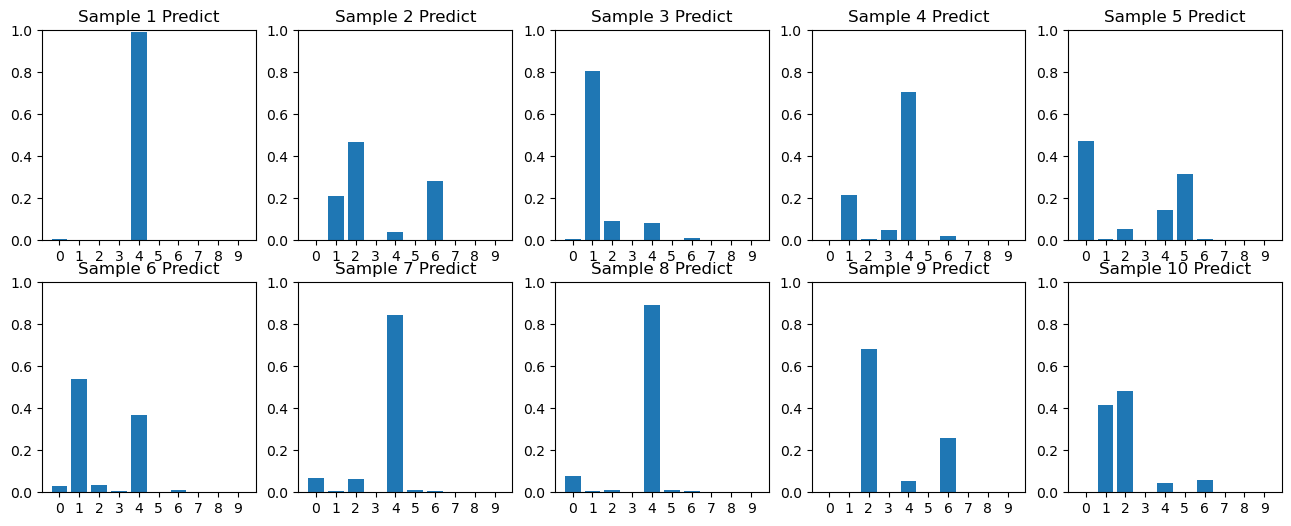

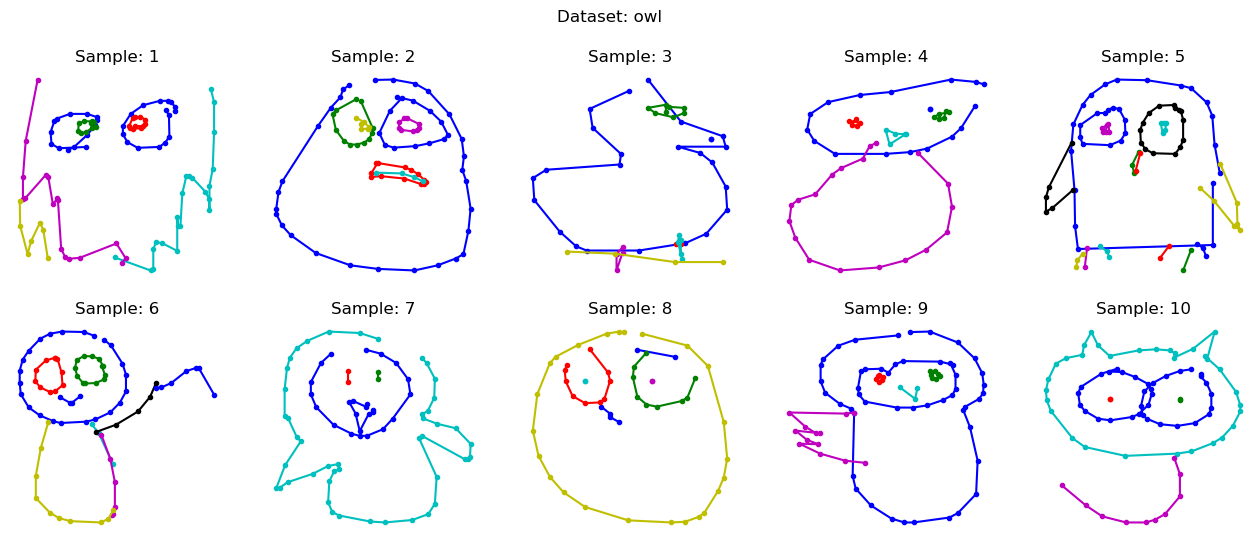

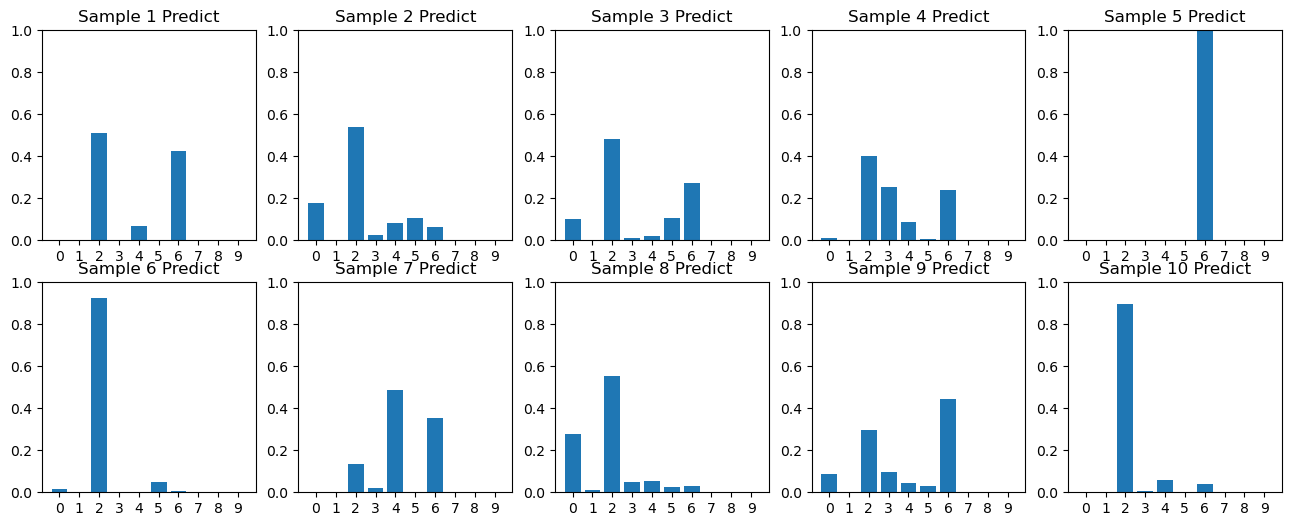

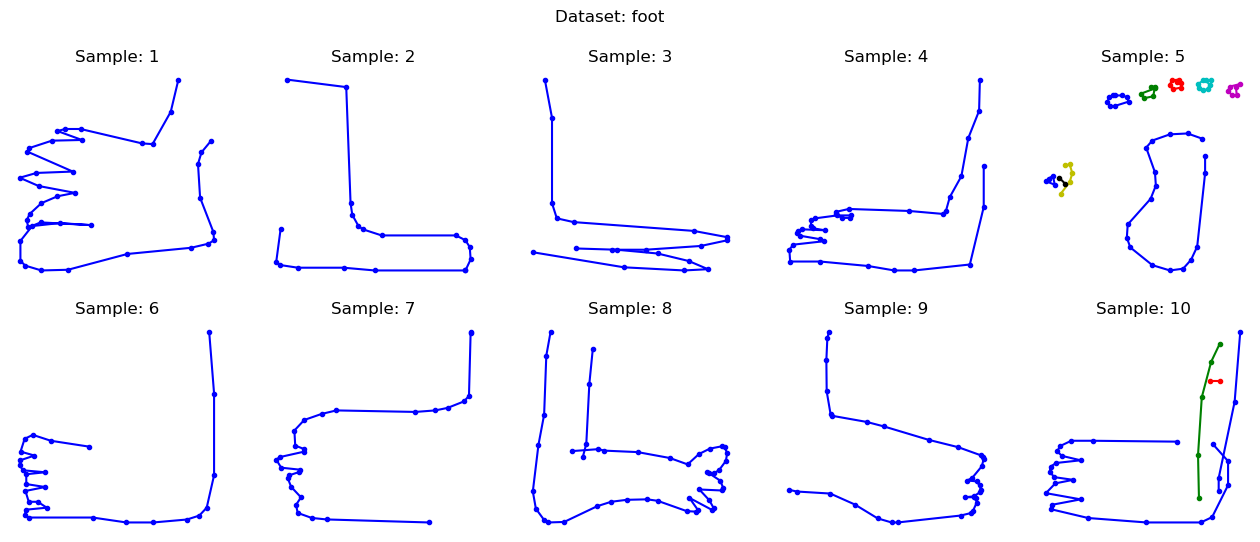

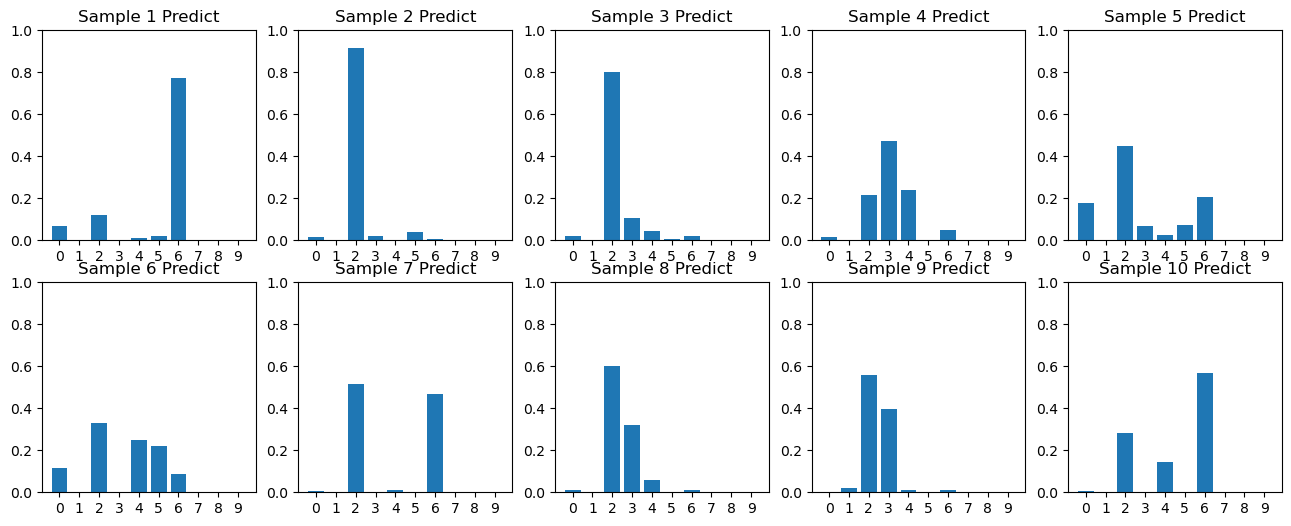

out data acc:0.000


In [ ]:
epochs = 10 # 读入一个过去保存的模型

# 加载模型
trained_model = BiLSTM(input_size, hidden_size, num_layers, num_classes)
trained_model.load_state_dict(torch.load(f'./trained_BiLSTM_lstm_model_{epochs}epochs.pth'))

# 模型测试
model_test(trained_model, device, in_test_data, 'in')
model_test(trained_model, device, ood_test_data, 'out')

## 2.6 分析
结果与之前CNN的时候一致，对于训练数据分布内的预测任务，表现良好，但是对于分布外的任务不具有任何预测能力。并且也可看到任何时候模型都不认为有图像属于789类别。